#### Notation
Over the whole project we tried to use the same notation that is used in the original paper [1].

 - $n$ - number of different states in the dynamical process  
 - $m$ - vector where $m_i$ is number of node's neighbors in each of n states, ($i = 0, ..., n-1$)  
 - $F_m(i->j)$ - the rate at which a node in state i changes to state j, given the $m$ 
 - $N$ - number of nodes in the network  
 - $k$ - degree ($k_min$, $k_max$, min and max degrees)  
 - $<k>$ - average degree in the network
 - $p_k$ - degree distribution (probability of k-degree node occurrence)  
 - $|m|=k$ - all possible ms where $\sum_{i=0}^{n-1}m_i = k$

### `SimulateProcess` object
An object that simulates the dynamical process, knowing the network, the transition matrix and states from the previous 
iteration.

### `CalculateProcess` object
A generic object for calculating multistate dynamical process which is then inherited by one of the generalized 
approximation framework.

#### `MeanField` framework
Mean Field is the most relaxed, therefore the most rough, estimate of the dynamical process within the three 
approximation frameworks. Where we assume that the states of each node in the network are independent. In the Mean Field 
approximation we consider following relations:

 - $x^i_k(t)$ - expected fraction of nodes in state i of degree k at time t  
 - $\omega^j(t) = \sum_{k=0}^{\inf} \frac{kp_k}{<k>} x^j_k(t)$ - probability that the neighbor of a node is in state j
 at time t   
 - $Mult_k(m, t) = \frac{k!}{m_0!...m_{n-1}!}(\omega^0(t))^{m_0}...(\omega^{n-1}(t))^{m_{n-1}}$ - probability that a k-degree node
 has m-neighbor in various states at time t  

The Mean Field evolution equation for $x^i_k(t)$ is:

$$\frac{d}{dt}x^i_k = - \sum_{j \neq i}x^i_k\sum_{|m|=k}Mult(m, t)F_m(i->j) + 
\sum_{j\neq i}x^j_k\sum_{|m|=k}Mult(m, t)F_m(j->ij)$$

Or having the matrix notation:

$$\frac{d}{dt}\mathbf(x)^i_k = \sum_{|m|=k}(\mathbf(R_m) - \mathbf(F_m^T))Mult(m, t)\mathbf(x)^i_k$$

In [1]:
import sys
sys.path.append('/Users/reketejmakrety/Documents/projects/multistate_dynamical_processes_networks')
import numpy as np
import matplotlib.pyplot as plt
from network.models.barabasi_albert import BarabasiAlbert
from multistate_processes.process import MultistateProcess
from multistate_processes.simulate import SimulateProcess
from multistate_processes.meanField import MeanField


In [2]:
N = 100
n = 3
num_infected = 3
T = 250

network = BarabasiAlbert(N, 2)

rate_matrix = np.array([
    ['0', 'beta*{1}', '0'], 
    ['0', '0', 'gamma'], 
    ['0', '0', '0']
])

sir_process = MultistateProcess(rate_matrix, gamma=0.02, beta=0.02)

states = [0] * N
infected_nodes = np.random.choice(list(range(N)), num_infected).tolist()

for i in infected_nodes[:-1]:
    states[i] = 1

states[infected_nodes[-1]] = 2

X = np.zeros((T, n, int(network.k_max)))
S = np.zeros((T, n))

degrees = network.degrees_list
for node in range(N):
    X[0][states[node]][degrees[node] - 1] += 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


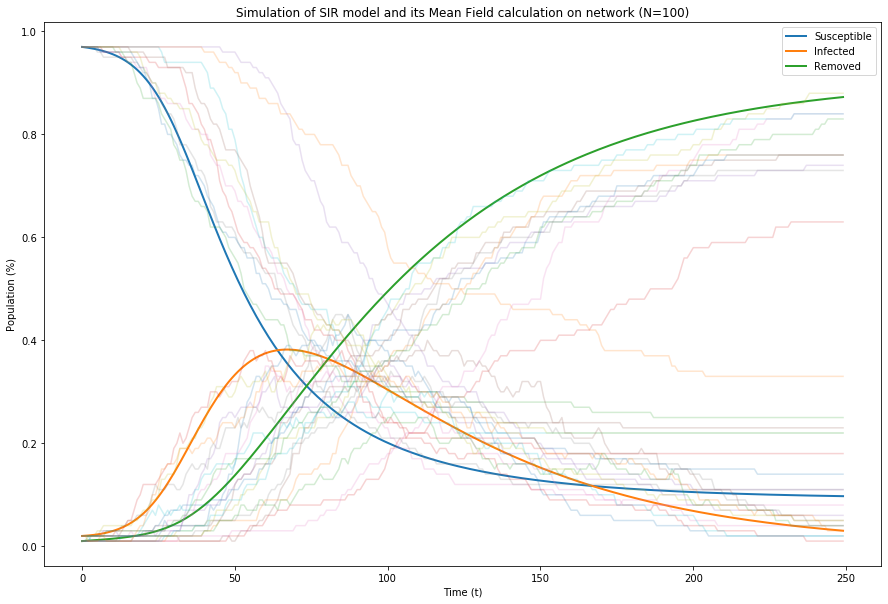

In [3]:
X = np.nan_to_num(X / np.sum(X[0], axis=0))
S[0] = np.array([N - num_infected, num_infected - 1, 1])

mean_field = MeanField(network, sir_process, T, X)

calculate_mean_field = iter(mean_field)
plt.figure(figsize=(15, 10))
for t in range(1, T):
    next(calculate_mean_field)

plt.plot(np.arange(T), mean_field.rho(calculate_mean_field.x), linewidth=2)

for i in range(10):
    sir = SimulateProcess(network, sir_process, T, states)
    simulate_sir = iter(sir)
    for t in range(1, T):
        s = next(simulate_sir)
        S[t] = np.histogram(s, bins=list(range(n + 1)))[0]
    
    plt.plot(np.arange(T), S / N, alpha=0.2)

plt.ylabel('Population (%)')
plt.xlabel('Time (t)')
plt.title(f'Simulation of SIR model and its Mean Field calculation on network (N={N})')
plt.legend(['Susceptible', 'Infected', 'Removed'])
plt.show()